# Text Preprocessing

BERT tokenizer and text preprocessing from the hugging face library to prepare the data for the BERT classification model. We also look at why the text needs to be pre-processed and used for the BERT classification model 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
root_path = "/content/gdrive/MyDrive/Collab-Notebooks/Sentiment-Analysis/"

In [3]:
!pip install transformers

     |████████████████████████████████| 1.5MB 6.6MB/s 
     |████████████████████████████████| 890kB 30.6MB/s 
     |████████████████████████████████| 2.9MB 26.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1a78f25950b1608345e4aa2054a849b7a475b2ffcbca284beabc8599d7884312
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [11]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 6,6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
df = pd.read_csv(root_path+"reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGOU1svA5gsifHKHFSziUGg7FDs9zR0HbVyXya...,trina croll,https://play-lh.googleusercontent.com/a-/AOh14...,Can't get into my account and it's been days g...,1,8,5.7.0.20,2020-12-21 01:58:55,NaN,NaN,most_relevant,com.anydo
1,gp:AOqpTOEJfVU5Os7_8CNOu_mpy2AlDz8kFxEFMeBMnxC...,Yiğitcan Sümbelli,https://play-lh.googleusercontent.com/a-/AOh14...,I am starting to hate this app! Every time the...,1,63,5.7.0.10,2020-12-02 15:52:24,"Hi, please note that these issues usually are ...",2020-12-03 20:47:02,most_relevant,com.anydo
2,gp:AOqpTOHhd6uZpuhbBDDxEB1SwF8zXXUh8sg6AMGlkBx...,Chris Keyes,https://play-lh.googleusercontent.com/a-/AOh14...,I paid premium for years. No more! This app ha...,1,24,5.7.0.10,2020-12-15 00:58:57,Sorry you feel this way. Any.do does not chang...,2020-12-17 09:28:09,most_relevant,com.anydo
3,gp:AOqpTOFSPaoOVarqwKF86e7-TPUyV6BanSXKRNFGb6G...,Jon Pember,https://play-lh.googleusercontent.com/-97UNn5D...,"Liked Any.do at first, enough that I even sign...",1,102,5.7.0.10,2020-11-22 23:42:56,Please note that Any.do integrates directly wi...,2020-11-25 13:30:01,most_relevant,com.anydo
4,gp:AOqpTOEA0ubPA5n0s_6lg0BHqfQqj0gi-KIdZF_I1yZ...,Lisa Pappas,https://play-lh.googleusercontent.com/a-/AOh14...,Constant crashing. After reading all the negat...,1,25,5.6.0.6,2020-10-21 17:45:24,NaN,NaN,most_relevant,com.anydo


In [13]:
df.shape

(16354, 12)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16354 entries, 0 to 16353
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16354 non-null  object
 1   userName              16354 non-null  object
 2   userImage             16354 non-null  object
 3   content               16354 non-null  object
 4   score                 16354 non-null  int64 
 5   thumbsUpCount         16354 non-null  int64 
 6   reviewCreatedVersion  13988 non-null  object
 7   at                    16354 non-null  object
 8   replyContent          8740 non-null   object
 9   repliedAt             8740 non-null   object
 10  sortOrder             16354 non-null  object
 11  appId                 16354 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


To check whether or not our dataset is balanced in terms of the dataset distribution that we have. We can check this with respect to the count of the different scores.

The distribution seems reasonable since (1,2) will be grouped and (4,5) will be grouped and 3 is double of that

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

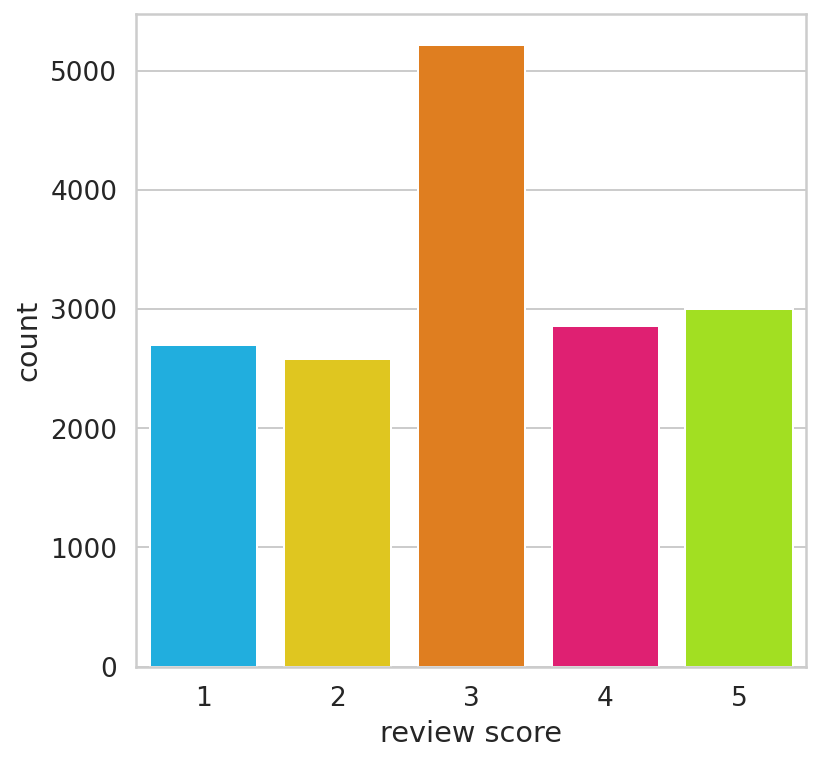

In [16]:
sns.countplot(df.score)
plt.xlabel('review score')

In [17]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <=2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [19]:
df['sentiment'] = df.score.apply(to_sentiment)

In [20]:
class_names = ['negative','neutral','positive']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

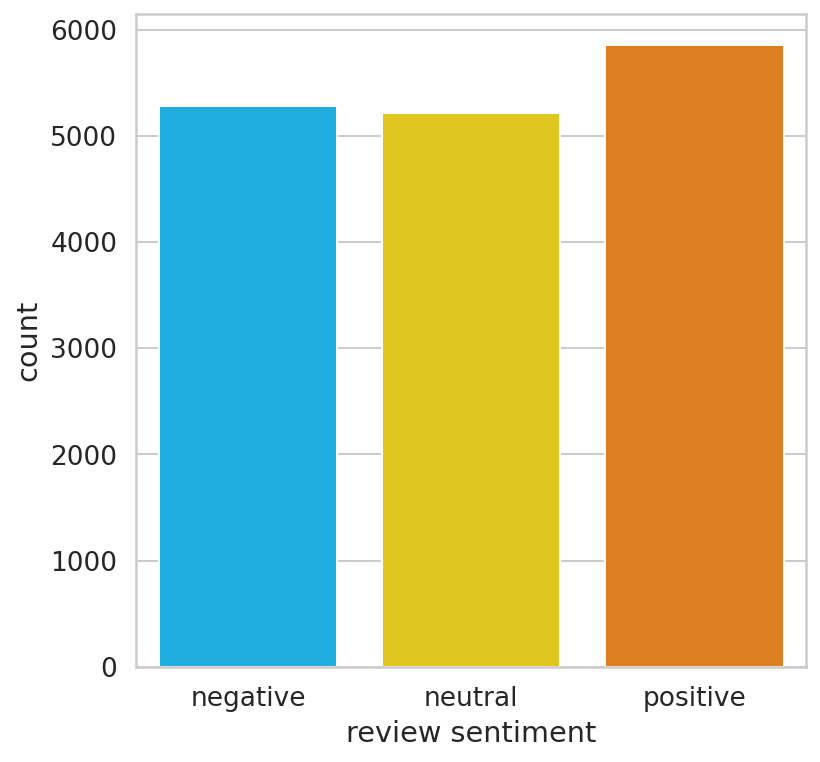

In [22]:
ax =sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

# Data Preprocessing

BERT transformer requires some special work on the text as preprocessing. Pretrained on v large dataset; and we are using it for sequence classification

In [66]:
#starting with the tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')


BERT requires special tokens which indicate separation between sentences.
This comes from the fact that BERT was initially built for Q/A systems and while
doing classification of sequences BERT requires a tokens

Seuqences must be of equal length, which means we'll have to do padding which will
append tokens of 0 meaning to the end of our sentences that we pass into the model

We also require an attention mask - each token that has a meaning should have a value
of 1 in the attention mask, else if it is a padding token attention mask should be 0

* Use a small piece of text to show how the tokenizer splits and works with the text

* Building a dataset, that will take the reviews, use the tokenizer internally, and build a dataset that is compatible with pytorch

In [67]:
sample_txt = "When was I last outside? I am stuck at home for 2 weeks."

In [68]:
tokens = tokenizer.tokenize(sample_txt)

In [69]:
print(tokens)
#keeps all the punctuation here

['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [70]:
#converting tokens to ids to pass to the bert model later

token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids))
print(len(tokens))
print(token_ids)

15
15
[2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


## Special Tokens

* SEP tokens
* Classification token
* Padding token
* Unknown token for something that is unrecognized

We use the ecode plus method to create all the steps for tokenization and data pre processing

In [71]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [72]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [73]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [74]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [75]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens=True,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [76]:
encoding['input_ids']

tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
         2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [77]:
len(encoding['input_ids'][0])

32

In [78]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

### Choosing Sequence Length
We can look at the distribution of the sentences in our token lengths and the choose one ideal one

We will just use the encode method of the tokenizer here

In [79]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


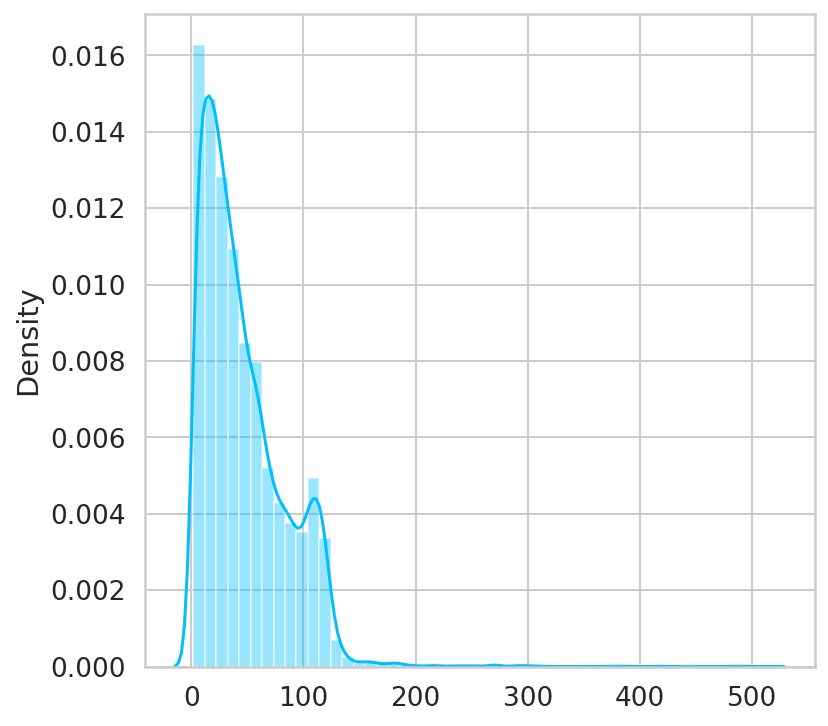

In [80]:
sns.distplot(token_lens)

Here the max length of 128 seems suitable enough for our distribution of tokens and initially, we can choose a len that may clip some tokens but allows the model to train relatively faster and also helps build a faster prototype for testing

## Creating a DATSET

In [81]:
class GPReviewDataset(Dataset):


  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  #takes the index of the element from the dataset
  def __getitem__(self, item):
    review = str(self.review[item])
    encoding = tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      add_special_tokens=True,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt'
    )
    return {
        'input_ids' : encoding['input_ids'],
        'attention_mask' : encoding['attention_mask'],
        'targets' : torch.tensor(self.target[item], dtype=torch.long)
    }
  

In [82]:
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 20

In [83]:
#splitting into train, test, val

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state=RANDOM_SEED)

In [84]:
df_train.shape, df_val.shape, df_test.shape

((13083, 13), (1635, 13), (1636, 13))

In [85]:
'''
wrapping all the dataframes into the pytorch dataloaders 
to be able to load and use in the bert pretrained model
'''

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review = df.content.to_numpy(),
      target = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [86]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [87]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [88]:
print(data['input_ids'].shape)

torch.Size([8, 1, 128])
